In [1]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def display_plot(image, title='', cmap=None):
    plt.imshow(image,cmap=cmap)
    plt.title(title)
    plt.show()

In [3]:
def contains(box1,box2):
    b1x,b1y,b1w,b1h=box1
    b2x,b2y,b2w,b2h=box2
    return b1x<b2x and b1y<b2y and (b1x+b1w)>(b2x+b2w) and (b1y+b1h)>(b2y+b2h)

In [17]:
def process_img(img, display=False):
    if display:
        display_plot(img,'Original image',None)


    #Convert to grayscale and denoise
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.fastNlMeansDenoising(img)
    if display:
        display_plot(img,'Grayscale and denoised','gray')


    #Histogram and percentile
    img_array = img.ravel()
    percentile = np.percentile(img_array,4)
    if display:
        plt.hist(img_array,256); 
        plt.show()
        print(percentile)


    #Find contours
    #1. Add binary threshold
    ret, thresh = cv2.threshold(img, percentile, 255, 0)
    if display:
        display_plot(thresh,'With binary threshold applied','gray')
        
    #Morphological opening
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN,  np.ones((3,3),np.uint8))
    if display:
        display_plot(thresh,'With Morphological opening','gray')

    #2. Find and draw contours
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    img_contours = cv2.drawContours(img.copy(), contours, -1, (0,255,0), 3)
    if display:
        display_plot(img_contours, 'Contours' , 'gray')
    
    #Add limit to bounding boxes size
    img_size = img.shape[0]*img.shape[1]
    max_area=0.5*img_size
    min_area=0.001*img_size

    #Find bounding boxes
    boxes=[]
    for contour in contours:
        x,y,w,h = cv2.boundingRect(contour)
        if max_area>(w*h)>min_area:
            boxes.append((x,y,w,h))
    
    img_boxes = img.copy()
    for box1 in boxes.copy():
        for box2 in boxes.copy():
            if contains(box2,box1):
                if box1 in boxes:
                    boxes.remove(box1)
    
    for box in boxes:
        x,y,w,h=box
        cv2.rectangle(img_boxes,(x,y),(x+w,y+h),(0,255,0),2)
    if display:
        display_plot(img_boxes,'Bounding boxes', 'gray')
        
    return img_boxes

## Test single image with intermediate steps displayed

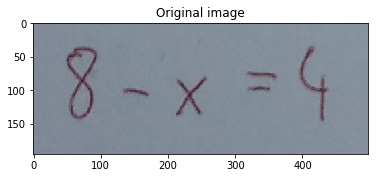

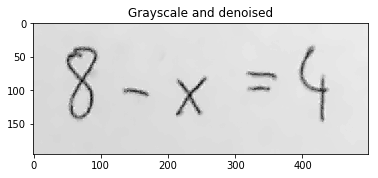

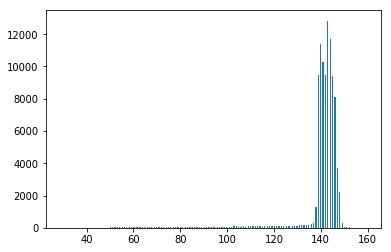

116.0


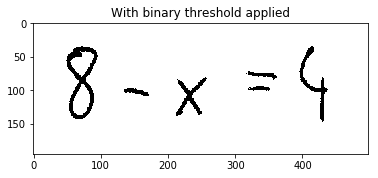

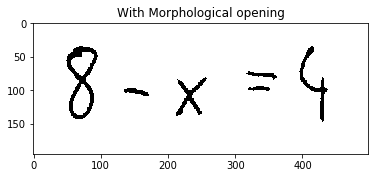

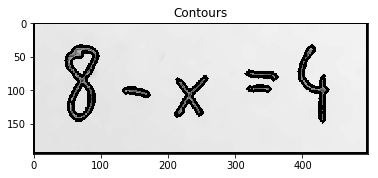

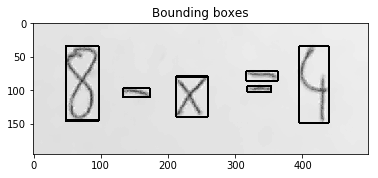

array([[141, 142, 141, ..., 149, 149, 149],
       [141, 142, 141, ..., 149, 149, 149],
       [142, 142, 142, ..., 149, 149, 149],
       ...,
       [139, 139, 139, ..., 145, 145, 145],
       [139, 139, 139, ..., 145, 145, 145],
       [139, 139, 139, ..., 145, 145, 145]], dtype=uint8)

In [18]:
img = cv2.imread('equations/11.png')
process_img(img,display=True)

## Tests for whole set

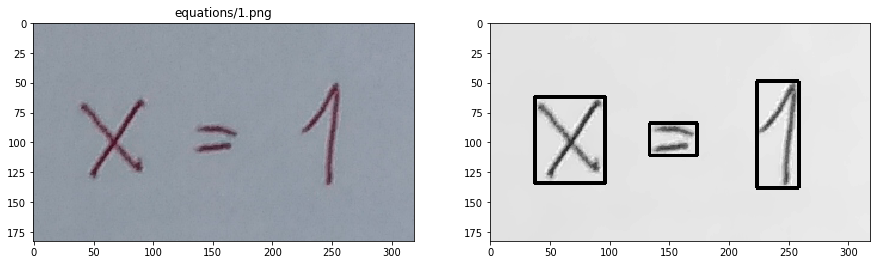

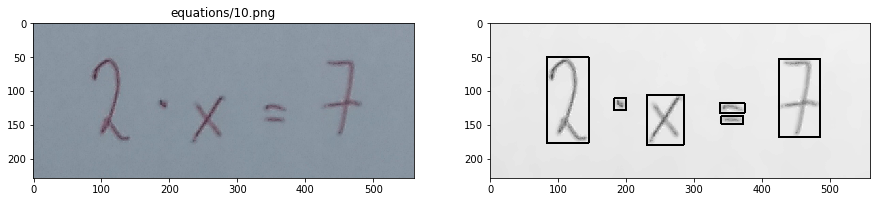

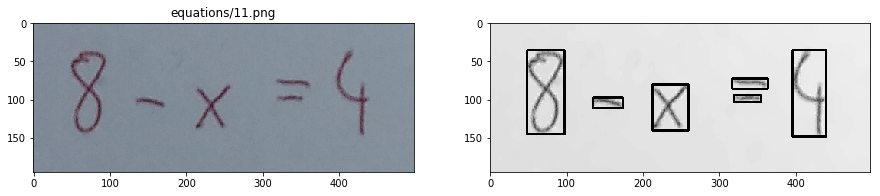

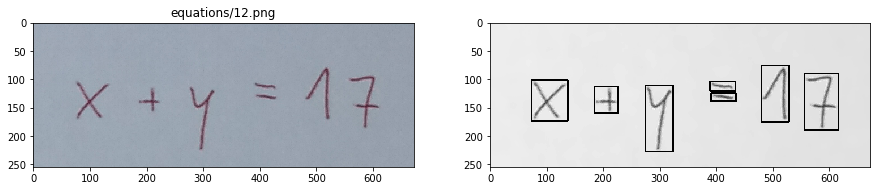

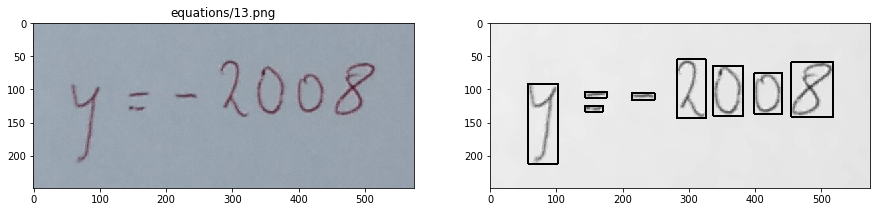

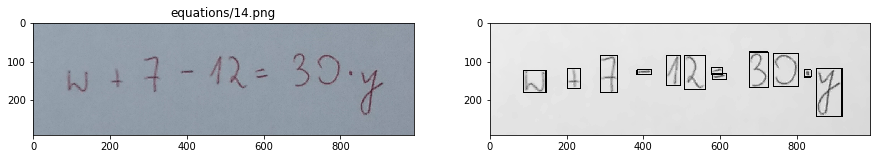

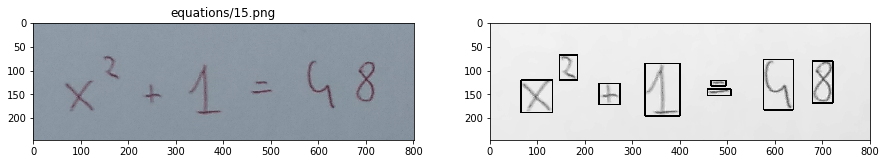

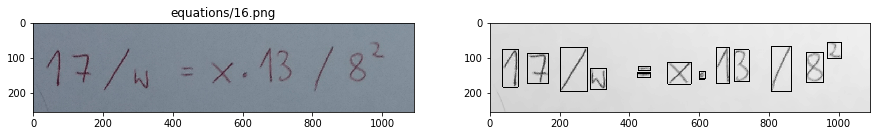

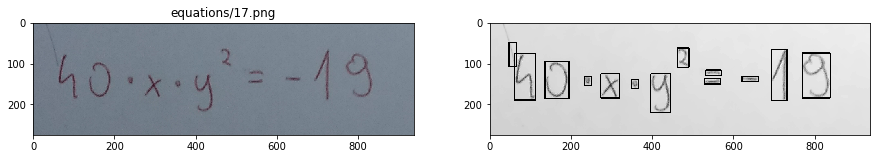

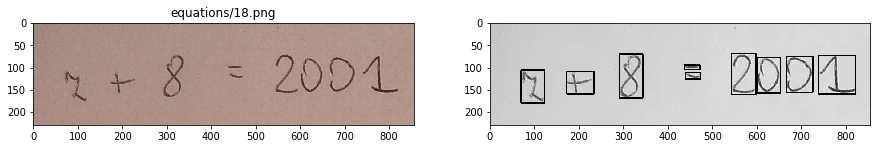

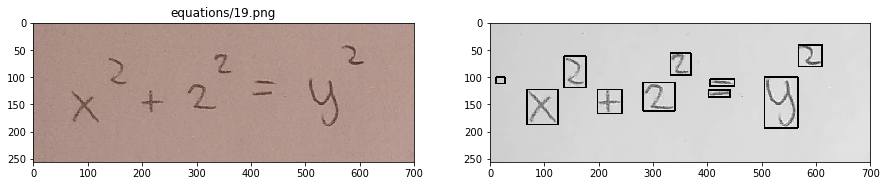

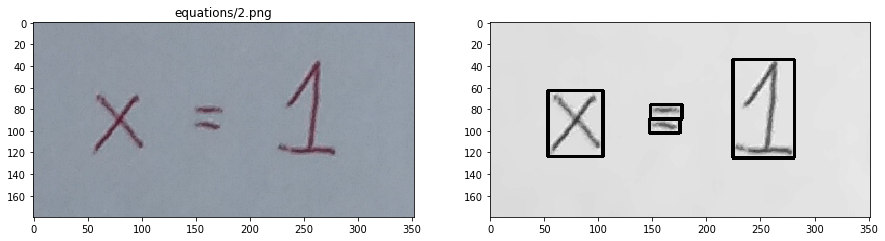

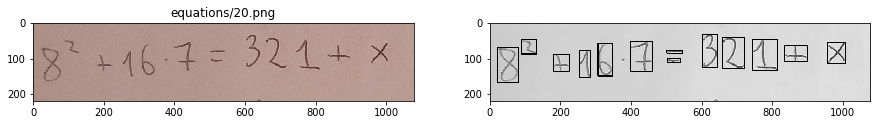

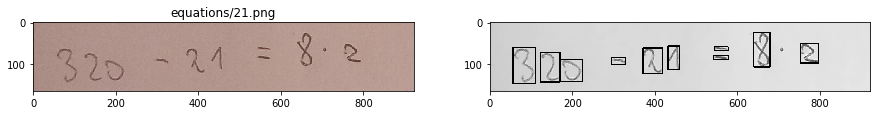

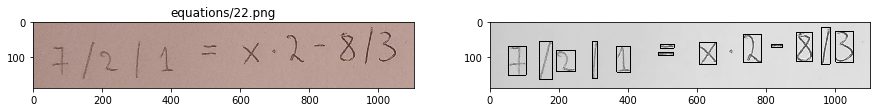

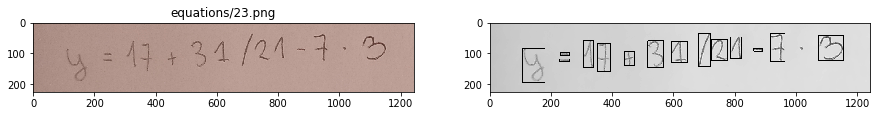

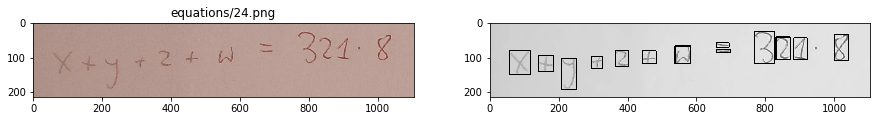

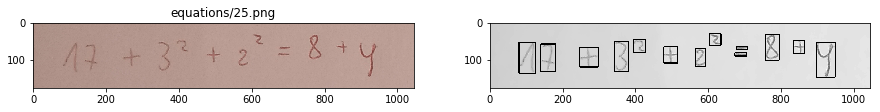

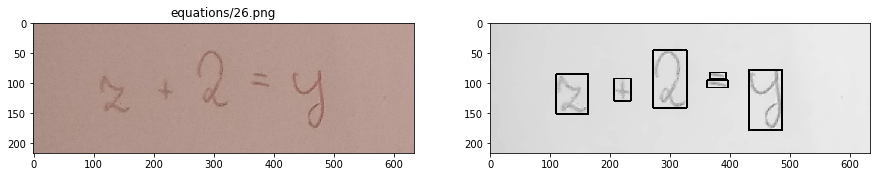

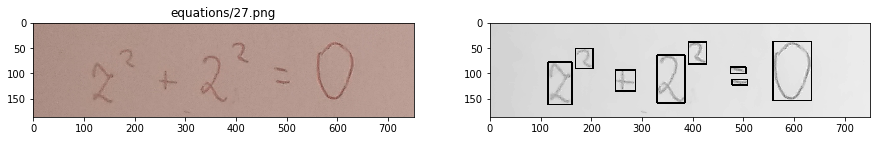

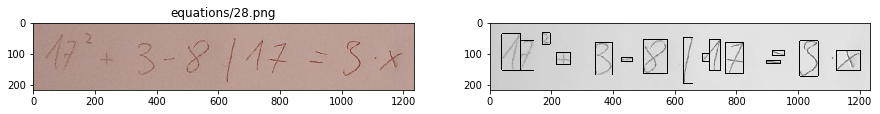

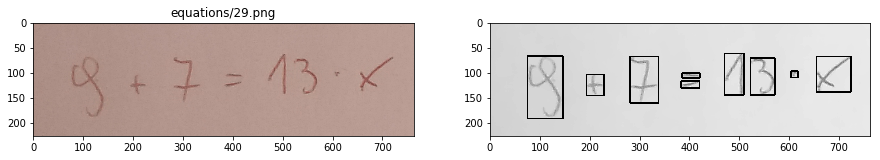

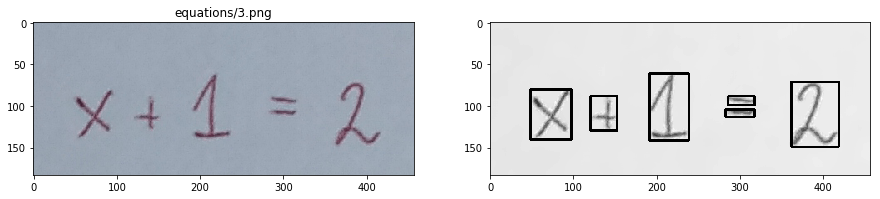

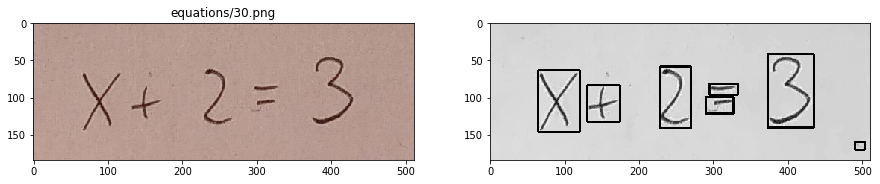

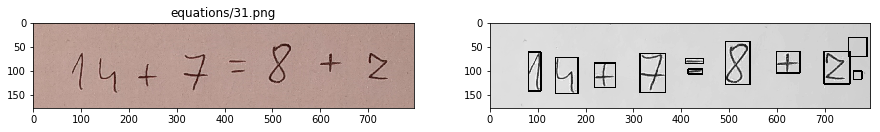

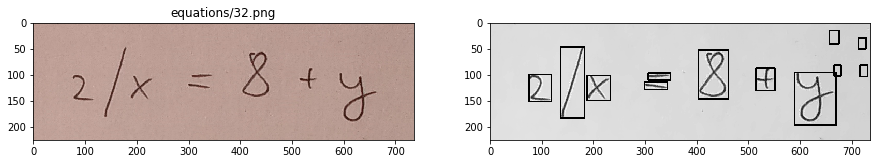

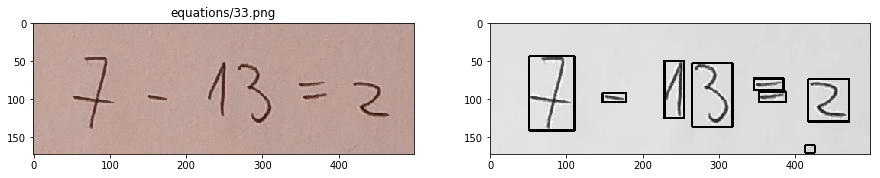

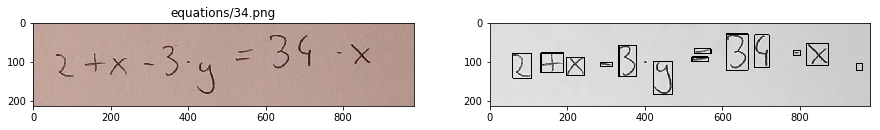

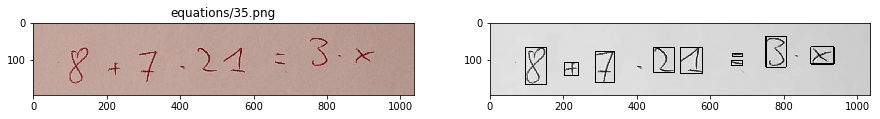

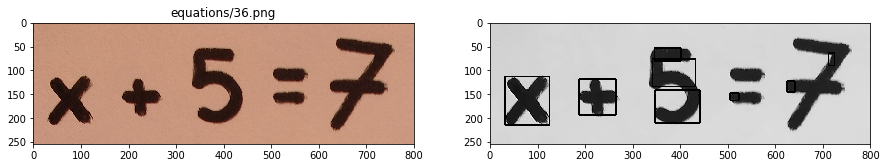

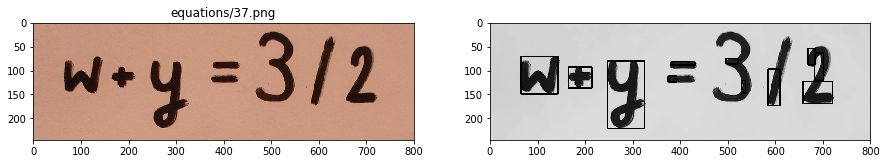

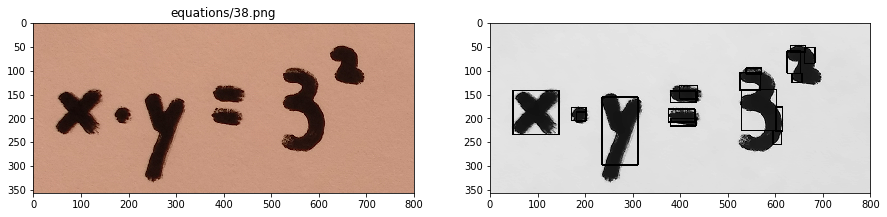

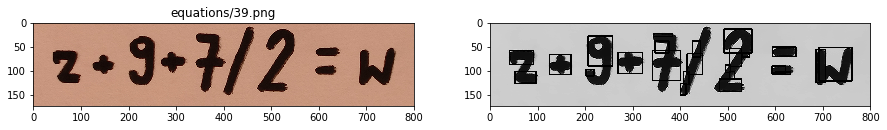

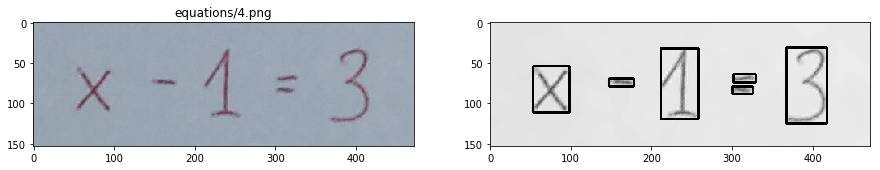

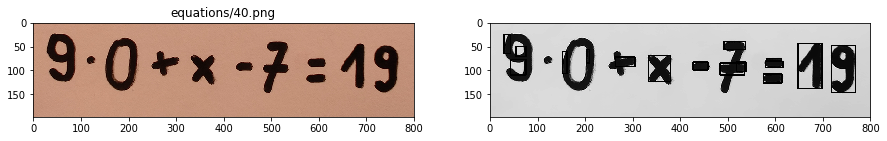

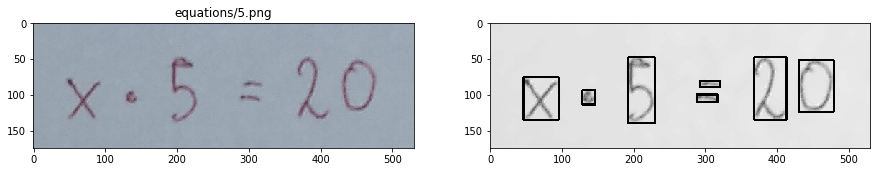

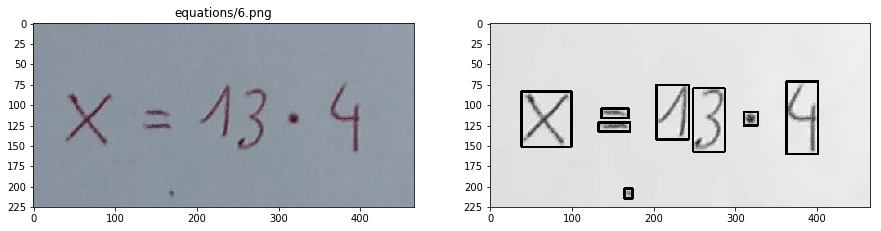

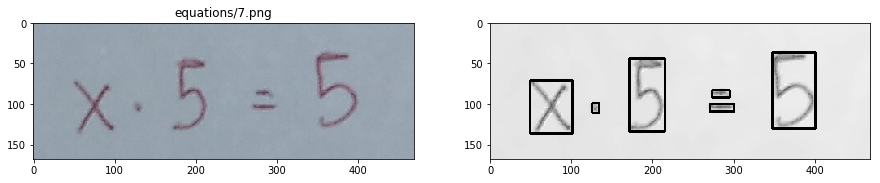

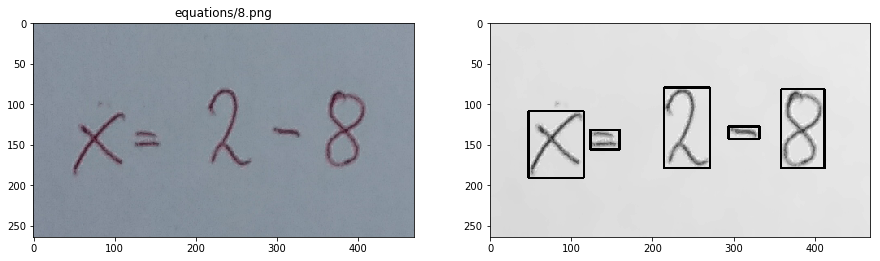

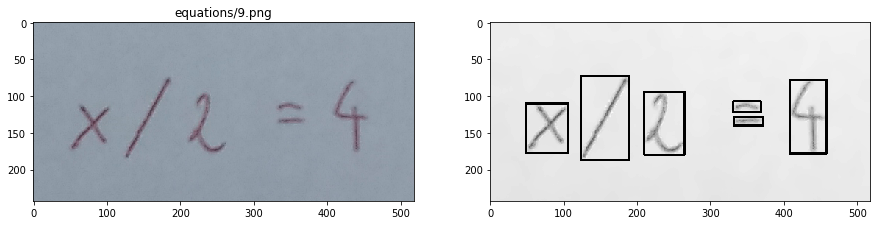

In [21]:
#Tests for whole set
DIR = 'equations'
for file in os.listdir(DIR):
    file=f'{DIR}/{file}'
    img = cv2.imread(file)
    plt.figure(figsize=(15,7))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title(file)
    img_boxes = process_img(img)
    plt.subplot(1, 2, 2)
    plt.imshow(img_boxes, cmap='gray')
    plt.show()